<a href="https://colab.research.google.com/github/Kudrettinkadir/Py-AI/blob/main/SVHN_KERAS_with_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import keras
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import cv2
import glob
from keras.optimizers import SGD

In [6]:
np.random.seed(20)

In [7]:
train_raw = loadmat('SVHN/train_32x32.mat')
test_raw = loadmat('SVHN/test_32x32.mat')

In [8]:
train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])

train_labels = train_raw['y']
test_labels = test_raw['y']

In [9]:
train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

In [10]:
train_images = train_images.astype('float64')
test_images = test_images.astype('float64')

In [11]:
train_labels = train_labels.astype('int64')
test_labels = test_labels.astype('int64')

In [12]:
train_images /=  225.0
test_images /=  255.0

In [13]:
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels,
                                                  test_size=0.15, random_state=22)

In [15]:
y_val.shape

(10989, 10)

In [18]:
datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

In [19]:

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',kernel_initializer='he_uniform',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
   
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, (3, 3), 
                        padding='same', kernel_initializer='he_uniform',
                           activation='relu'),
    keras.layers.BatchNormalization(),
   
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        kernel_initializer='he_uniform',
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        kernel_initializer='he_uniform',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
   
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(
                   '/kaggle/working/best_cnn.h5', 
                   save_best_only=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=70, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/70
487/487 [==============================] - 323s 622ms/step - loss: 2.8649 - accuracy: 0.2305 - val_loss: 0.8203 - val_accuracy: 0.7578
Epoch 2/70
487/487 [==============================] - 293s 602ms/step - loss: 0.9908 - accuracy: 0.6747 - val_loss: 0.4811 - val_accuracy: 0.8537
Epoch 3/70
487/487 [==============================] - 296s 607ms/step - loss: 0.7009 - accuracy: 0.7752 - val_loss: 0.3892 - val_accuracy: 0.8812
Epoch 4/70
487/487 [==============================] - 300s 616ms/step - loss: 0.5770 - accuracy: 0.8157 - val_loss: 0.3403 - val_accuracy: 0.9016
Epoch 5/70
487/487 [==============================] - 305s 627ms/step - loss: 0.5189 - accuracy: 0.8383 - val_loss: 0.3088 - val_accuracy: 0.9102
Epoch 6/70
487/487 [==============================] - 311s 639ms/step - loss: 0.4694 - accuracy: 0.8555 - val_loss: 0.2772 - val_accuracy: 0.9225
Epoch 7/70
487/487 [==============================] - 313s 644ms/step - loss: 0.4364 - accuracy: 0.8637 - val_loss: 0.2982 -

In [21]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

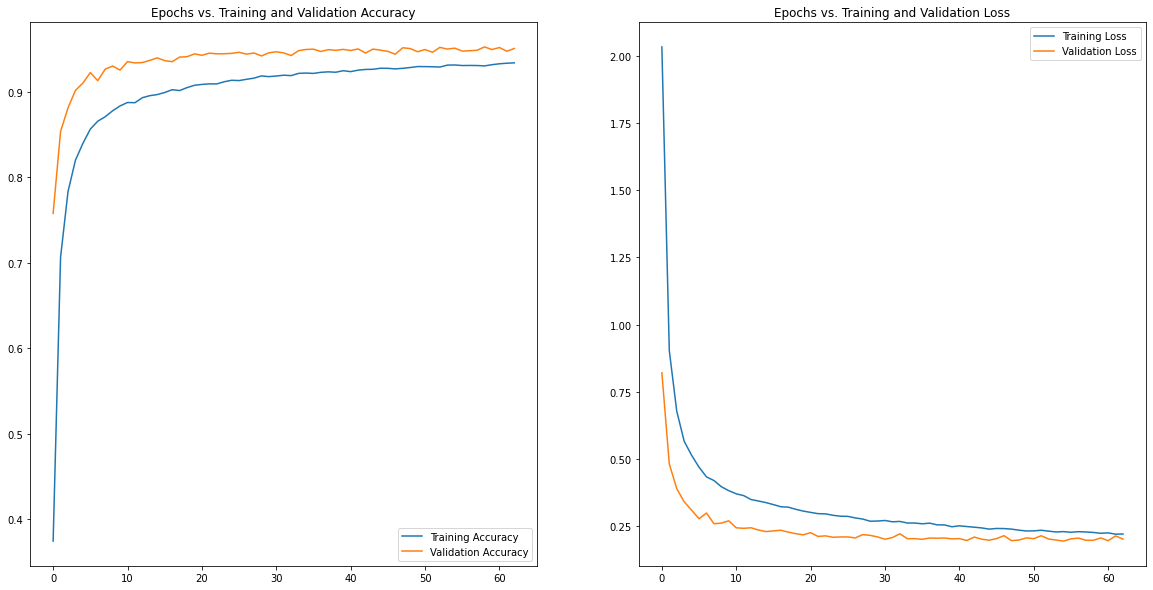

In [22]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

In [23]:
test_loss, test_acc = model.evaluate(x=test_images, y=test_labels, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.9563 
Test loss is: 0.1775


In [28]:
y_pred = model.predict(X_train)

In [29]:
y_pred = lb.inverse_transform(y_pred, lb.classes_)
y_train = lb.inverse_transform(y_train, lb.classes_)

AxisError: ignored

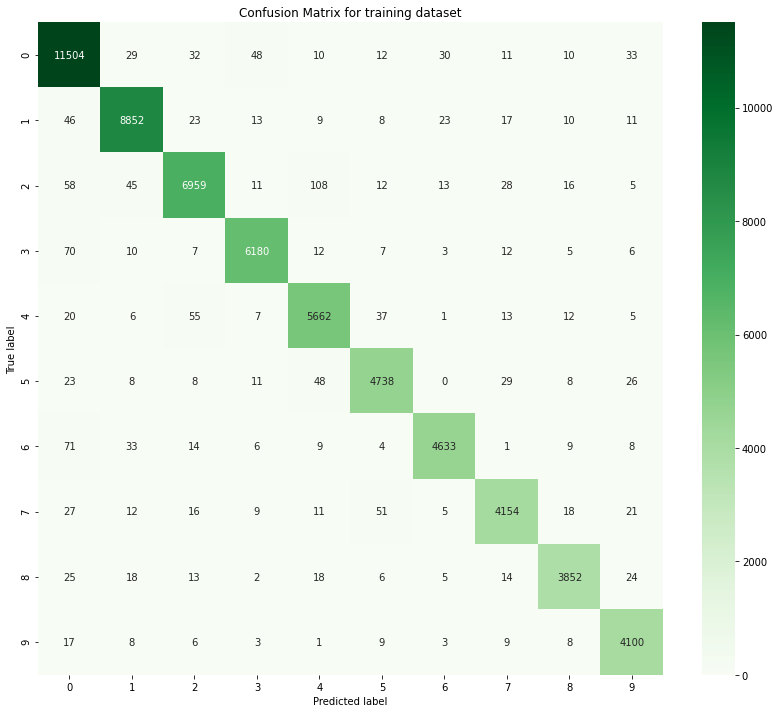

In [30]:
matrix = confusion_matrix(y_train, y_pred, labels=lb.classes_)

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()